In [1]:
import os
import cv2
import numpy as np
import histomicstk as htk
import scipy as sp
import skimage.io
import skimage.measure
import skimage.color
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import time

from glob import glob
from os.path import expanduser, join, basename

plt.rcParams['figure.figsize'] = 15,15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

In [2]:
# Reading in color default. Change to zero for grayscale
def read_image(filename,mode=1):
    try:
        img = cv2.imread(filename,mode)
    except e:
        raise e
    if img is None:
        print('Check your path. Not a file path. Probably a folder path.')
    return img

def write_image(filename,img):
    try:
        cv2.imwrite(filename,img)
    except e:
        raise e
        
def image_check(image_name):
    if image_name.split('.')[-1] not in ['jpg','jpeg','png']:
        return False
    return True
    
def cal_iou(img1, img2):
    intersection = np.sum(img1*img2)
    union = np.sum(img1 + img2) - intersection
    
    return intersection/union

In [15]:
def segment(image_path, ref_path, output_path, gt_path):
    
    #Constants:
    foreground_threshold = 180
    min_radius = 5
    max_radius = 100
    min_nucleus_area = 150
    
    #reading images
    imInput = skimage.io.imread(image_path)[:, :, :3]
    imReference = skimage.io.imread(ref_path)[:, :, :3]
    gt = skimage.io.imread(gt_path) #[:,:,0]

    # Get the mean and standard deviation of reference image in LAB colorspace
    meanRef, stdRef = htk.preprocessing.color_conversion.lab_mean_std(imReference)

    # Perform Reinhard Color Normalization on Input Image
    imNmzd = htk.preprocessing.color_normalization.reinhard(imInput,meanRef,stdRef)

    # Macenko PCA to get the stain vectors 
    I_0 = 255
    w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(imNmzd,I_0=255)

    # Perform the deconvolution using the stain vectors
    deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, w_est,I_0)

    #stains = ['hematoxylin','eosin','null']
    #In this case we are taking eosin, that is why 1, else 0 in next line
    imNucleiStain = deconv_result.Stains[:,:,1]

    # Now we do segmentation based on a fixed intensity value.
    imFgndMask = sp.ndimage.morphology.binary_fill_holes(imNucleiStain<foreground_threshold)

    imLog = htk.filters.shape.clog(imNucleiStain, imFgndMask,\
                                   sigma_min=min_radius * np.sqrt(2),\
                                   sigma_max=max_radius * np.sqrt(2))

    # detect and segment nuclei using local maximum clustering
    local_max_search_radius = 10
    imNucleiSegMask1, Seeds, Max = htk.segmentation.nuclear.max_clustering(imLog[0], imFgndMask, local_max_search_radius)

    # filter out small objects
    imNucleiSegMask = htk.segmentation.label.area_open(imNucleiSegMask1, min_nucleus_area).astype(np.int)

    imNucleicompact = htk.segmentation.label.compact(imNucleiSegMask, compaction=3)
    k= (imNucleicompact==-1)
    imNucleicompact1=np.copy(k)
    # plt.rcParams['figure.figsize'] = 15,15    
    for ii in range(0,imNucleicompact.shape[0]):
        for jj in range(0,imNucleicompact.shape[1]):
            if imNucleicompact[ii,jj]>0:
                imNucleicompact1[ii,jj]=1

    imNucleicompact2 = skimage.measure.label(imNucleicompact1,connectivity = 1)
    # imInput2 = np.copy(imNmzd)
    # plt.rcParams['figure.figsize'] = 1, 1

    mask_generated = np.copy(imNucleicompact2)
    mask_generated[mask_generated>0] = 1
    gt[gt>0] = 1

    iou_cal = cal_iou(gt, mask_generated)
    
    mask_generated[mask_generated>0] = 255
    cv2.imwrite(os.path.join(output_path , image_path.split('/')[-1]), mask_generated)
    
    return iou_cal

In [4]:
image_path = "Input_Images/01_1.png"
ref_path = "BM_GRAZ_HE_0007_01.png"
output_path = "Output_Images/"
gt_path = "Ground_Truth/01_1.png"

iou = segment(image_path, ref_path, output_path, gt_path)

print(iou)

/home/satya/Vijay/histomics/HistomicsTK/histomicstk/preprocessing/color_conversion/rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)


0.6879188144329897


In [32]:
iou_list = []
ref_path = "BM_GRAZ_HE_0007_01.png"

#For TNBC
# input_dir = "Input_Images"
# gt_dir = "Ground_Truth"
# inputs = glob(join(input_dir, '*.png'))
# gts = glob(join(gt_dir, '*.png'))


#For PSB
input_dir = "training/image/"
gt_dir = "training/gt/"
inputs = glob(join(input_dir, '*.tiff'))
inputs = sorted(inputs, key=lambda x: int(x.split('_')[0].split('/')[-1]))

gts = glob(join(gt_dir, '*.bmp'))
gts = sorted(gts, key=lambda x: int(x.split('_')[0].split('/')[-1]))

output_dir = "Output_Images"

start_time = time.time()
if len(inputs) == len(gts):
    for i in range(len(inputs)):
        print("Processing {} & {}".format(inputs[i], gts[i]))
        iou = segment(inputs[i], ref_path, output_dir, gts[i])
        iou_list.append(iou)
        print("IOU: {}".format(iou))
    print("Completed processing all images")    

print("----------Total Time Taken: {} minutes-----------".format((time.time()-start_time)/60))

Processing training/image/1_sample.tiff & training/gt/1_gt.bmp
IOU: 0.46864086592464005
Processing training/image/2_sample.tiff & training/gt/2_gt.bmp
IOU: 0.497158273381295
Processing training/image/3_sample.tiff & training/gt/3_gt.bmp
IOU: 0.48708981001727114
Processing training/image/4_sample.tiff & training/gt/4_gt.bmp
IOU: 0.5809418376905391
Processing training/image/5_sample.tiff & training/gt/5_gt.bmp
IOU: 0.48886494252873564
Processing training/image/6_sample.tiff & training/gt/6_gt.bmp
IOU: 0.49511029411764707
Processing training/image/7_sample.tiff & training/gt/7_gt.bmp
IOU: 0.3702418856626907
Processing training/image/8_sample.tiff & training/gt/8_gt.bmp
IOU: 0.32537075744003185
Processing training/image/9_sample.tiff & training/gt/9_gt.bmp
IOU: 0.23994687033040013
Processing training/image/10_sample.tiff & training/gt/10_gt.bmp
IOU: 0.4312161695266613
Processing training/image/11_sample.tiff & training/gt/11_gt.bmp
IOU: 0.3623373309517734
Processing training/image/12_sampl

IOU: 0.3820699203876774
Processing training/image/95_sample.tiff & training/gt/95_gt.bmp
IOU: 0.5607092714887422
Processing training/image/96_sample.tiff & training/gt/96_gt.bmp
IOU: 0.5597804782438259
Processing training/image/97_sample.tiff & training/gt/97_gt.bmp
IOU: 0.6459077760762294
Processing training/image/98_sample.tiff & training/gt/98_gt.bmp
IOU: 0.5183057625886203
Processing training/image/99_sample.tiff & training/gt/99_gt.bmp
IOU: 0.39223260964742845
Processing training/image/100_sample.tiff & training/gt/100_gt.bmp
IOU: 0.43375886524822693
Processing training/image/101_sample.tiff & training/gt/101_gt.bmp
IOU: 0.5799096713907491
Processing training/image/102_sample.tiff & training/gt/102_gt.bmp
IOU: 0.27922301450700765
Processing training/image/103_sample.tiff & training/gt/103_gt.bmp
IOU: 0.6121713886350196
Processing training/image/104_sample.tiff & training/gt/104_gt.bmp
IOU: 0.0
Processing training/image/105_sample.tiff & training/gt/105_gt.bmp
IOU: 0.45658010222520

IOU: 0.3719146783043183
Processing training/image/186_sample.tiff & training/gt/186_gt.bmp
IOU: 0.35109433713494625
Processing training/image/187_sample.tiff & training/gt/187_gt.bmp
IOU: 0.43853137807222214
Processing training/image/188_sample.tiff & training/gt/188_gt.bmp
IOU: 0.4017406122573185
Processing training/image/189_sample.tiff & training/gt/189_gt.bmp
IOU: 0.3535118219749652
Processing training/image/190_sample.tiff & training/gt/190_gt.bmp
IOU: 0.5929149112826347
Processing training/image/191_sample.tiff & training/gt/191_gt.bmp
IOU: 0.6325524925010713
Processing training/image/192_sample.tiff & training/gt/192_gt.bmp
IOU: 0.5701345866267892
Processing training/image/193_sample.tiff & training/gt/193_gt.bmp
IOU: 0.5380548829701373
Processing training/image/194_sample.tiff & training/gt/194_gt.bmp
IOU: 0.46575120639958545
Processing training/image/195_sample.tiff & training/gt/195_gt.bmp
IOU: 0.48440909931570186
Processing training/image/196_sample.tiff & training/gt/196_gt

IOU: 0.4871997254632807
Processing training/image/277_sample.tiff & training/gt/277_gt.bmp
IOU: 0.5083650707290533
Processing training/image/278_sample.tiff & training/gt/278_gt.bmp
IOU: 0.6316431504899768
Processing training/image/279_sample.tiff & training/gt/279_gt.bmp
IOU: 0.3826968907609599
Processing training/image/280_sample.tiff & training/gt/280_gt.bmp
IOU: 0.2968361180234625
Processing training/image/281_sample.tiff & training/gt/281_gt.bmp
IOU: 0.6227632218442097
Processing training/image/282_sample.tiff & training/gt/282_gt.bmp
IOU: 0.5068202611660984
Processing training/image/283_sample.tiff & training/gt/283_gt.bmp
IOU: 0.3800691763998195
Processing training/image/284_sample.tiff & training/gt/284_gt.bmp
IOU: 0.5381208478329642
Processing training/image/285_sample.tiff & training/gt/285_gt.bmp
IOU: 0.3640130281612124
Processing training/image/286_sample.tiff & training/gt/286_gt.bmp
IOU: 0.5941565020059164
Processing training/image/287_sample.tiff & training/gt/287_gt.bmp

IOU: 0.32332590594581917
Processing training/image/367_sample.tiff & training/gt/367_gt.bmp
IOU: 0.6046103253408256
Processing training/image/368_sample.tiff & training/gt/368_gt.bmp
IOU: 0.5374654726508208
Processing training/image/369_sample.tiff & training/gt/369_gt.bmp
IOU: 0.587513962410762
Processing training/image/370_sample.tiff & training/gt/370_gt.bmp
IOU: 0.3107235407840072
Processing training/image/371_sample.tiff & training/gt/371_gt.bmp
IOU: 0.25013511290739476
Processing training/image/372_sample.tiff & training/gt/372_gt.bmp
IOU: 0.47199961144300356
Processing training/image/373_sample.tiff & training/gt/373_gt.bmp
IOU: 0.2601632979330821
Processing training/image/374_sample.tiff & training/gt/374_gt.bmp
IOU: 0.0
Processing training/image/375_sample.tiff & training/gt/375_gt.bmp
IOU: 0.0
Processing training/image/376_sample.tiff & training/gt/376_gt.bmp
IOU: 0.0
Processing training/image/377_sample.tiff & training/gt/377_gt.bmp
IOU: 0.21425240350121968
Processing traini

IOU: 0.38235294117647056
Processing training/image/458_sample.tiff & training/gt/458_gt.bmp
IOU: 0.23448811734829247
Processing training/image/459_sample.tiff & training/gt/459_gt.bmp
IOU: 0.46202874966097096
Processing training/image/460_sample.tiff & training/gt/460_gt.bmp
IOU: 0.46962381980260015
Processing training/image/461_sample.tiff & training/gt/461_gt.bmp
IOU: 0.6179689439807475
Processing training/image/462_sample.tiff & training/gt/462_gt.bmp
IOU: 0.5652697063567241
Processing training/image/463_sample.tiff & training/gt/463_gt.bmp
IOU: 0.6691513121161362
Processing training/image/464_sample.tiff & training/gt/464_gt.bmp
IOU: 0.5194913881539873
Processing training/image/465_sample.tiff & training/gt/465_gt.bmp
IOU: 0.6555003137519911
Processing training/image/466_sample.tiff & training/gt/466_gt.bmp
IOU: 0.6417162235218952
Processing training/image/467_sample.tiff & training/gt/467_gt.bmp
IOU: 0.0
Processing training/image/468_sample.tiff & training/gt/468_gt.bmp
IOU: 0.615

IOU: 0.5195974990230559
Processing training/image/549_sample.tiff & training/gt/549_gt.bmp
IOU: 0.5907784999023737
Processing training/image/550_sample.tiff & training/gt/550_gt.bmp
IOU: 0.47184443765281175
Processing training/image/551_sample.tiff & training/gt/551_gt.bmp
IOU: 0.4692898272552783
Processing training/image/552_sample.tiff & training/gt/552_gt.bmp
IOU: 0.0
Processing training/image/553_sample.tiff & training/gt/553_gt.bmp
IOU: 0.4530413291226143
Processing training/image/554_sample.tiff & training/gt/554_gt.bmp
IOU: 0.4599734903363028
Processing training/image/555_sample.tiff & training/gt/555_gt.bmp
IOU: 0.5761931761331421
Processing training/image/556_sample.tiff & training/gt/556_gt.bmp
IOU: 0.46952942926563196
Processing training/image/557_sample.tiff & training/gt/557_gt.bmp
IOU: 0.3955453314127233
Processing training/image/558_sample.tiff & training/gt/558_gt.bmp
IOU: 0.3151294225302461
Processing training/image/559_sample.tiff & training/gt/559_gt.bmp
IOU: 0.28824

IOU: 0.3323370954422116
Processing training/image/640_sample.tiff & training/gt/640_gt.bmp
IOU: 0.0
Processing training/image/641_sample.tiff & training/gt/641_gt.bmp
IOU: 0.4780252028310029
Processing training/image/642_sample.tiff & training/gt/642_gt.bmp
IOU: 0.5174156095463341
Processing training/image/643_sample.tiff & training/gt/643_gt.bmp
IOU: 0.46050944525173093
Processing training/image/644_sample.tiff & training/gt/644_gt.bmp
IOU: 0.4378648233486943
Processing training/image/645_sample.tiff & training/gt/645_gt.bmp
IOU: 0.446356021467623
Processing training/image/646_sample.tiff & training/gt/646_gt.bmp
IOU: 0.40989269439952963
Completed processing all images
----------Total Time Taken: 261.4579337318738 minutes-----------


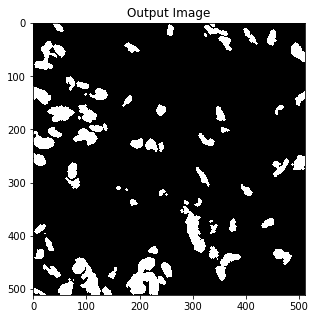

In [7]:
im = skimage.io.imread("Output_Images/01_1.png")
plt.figure(figsize=(5,5))
plt.imshow(im)
plt.title('Output Image')
plt.show()

In [33]:
np.mean(np.array(iou_list))

0.4004594366097121

In [9]:
len(iou_list)

50

In [16]:
image_path = "training/image/52_sample.tiff"
ref_path = "BM_GRAZ_HE_0007_01.png"
output_path = "Output_Images/"
gt_path = "training/gt/52_gt.bmp"

iou = segment(image_path, ref_path, output_path, gt_path)

print(iou)

0.4855272340566947
